# **In-Class Assignment: Document Clustering**

## *IS 5150*
## Name: KEY

In this in-class assignment we will utilize the same `TMDB movies dataset` as we did in the previous activity, however, we will now group movies together based off of different clustering methods. We will examine the pros and cons of these different methods and consider the different ways that they group together movies of similar taglines and overviews.

We begin as always by loading our required dependencies, loading in the dataset, and performing some cleaning/preporcessing steps.

In [ ]:
import pandas as pd
import nltk
import re
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')

!pip install kneed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

from collections import Counter

In [ ]:
from kneed import KneeLocator

In [ ]:
df = pd.read_csv("/content/tmdb_5000_movies.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4802 non-null   int64  
 1   genres                4802 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4802 non-null   int64  
 4   keywords              4802 non-null   object 
 5   original_language     4802 non-null   object 
 6   original_title        4802 non-null   object 
 7   overview              4799 non-null   object 
 8   popularity            4802 non-null   float64
 9   production_companies  4802 non-null   object 
 10  production_countries  4802 non-null   object 
 11  release_date          4801 non-null   object 
 12  revenue               4802 non-null   int64  
 13  runtime               4800 non-null   float64
 14  spoken_languages      4802 non-null   object 
 15  status               

In [ ]:
df = df[['title', 'tagline', 'overview', 'genres', 'popularity']]
df.tagline.fillna('', inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

4799

## **1) Cluster Similar Movies - K-Means Clustering Analysis**

We first begin with clustering movies via KMeans, a type of partition-based clustering. The pipeline for performing this analysis includes:

* Feature Engineering
* Clustering using Kmeans algorithm
* Find an optimal value for K
* Preparing movie clusters

Similarity analysis was one way of grouping together movies, clustering analysis serves as a different approach. Let's see how these methods differ...

> ### **A) Feature Engineering - Term Frequencies**

In [ ]:
stop_words = stop_words + ['one', 'two', 'get']
tv = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words = stop_words) # in jupyter notebooks its stopwords = 
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix.shape

(4799, 3012)

**Let's talk through some of these parameters in our CountVectorizer method...**

Extract bag of words term frequencies for unigrams and bigframs (range = 1,2), each feature (gram) must occur in at least 10 documents, but no more than 80% of the documents to be retained. 

> ### **B) Clustering using KMeans**

K must be user defined, and it can be difficult to know where to start in terms of the number of clusters. We'll try k = 3 first, then utilize a more empirical method of determining the optimal number of clusters.

In [ ]:
km = KMeans(n_clusters = 3,
            max_iter = 10000,
            n_init = 50,
            random_state = 42).fit(tv_matrix)
Counter(km.labels_)

Counter({0: 3337, 2: 198, 1: 1264})

**What is the distribution of movie clusters looking like?**

> ### **C) Find the optimal value for K - Elbow rule**

We started off with 6 clusters, but perhaps there is a more optimal number. Let's examine a range of k values and use the Elbow rule method using the `KneeLocator` method to guide our selection of k.

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}                                                                   # create a kmeans initialization dictionary


sse = []                                                            # create empty list for SSE values
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tv_matrix)
    sse.append(kmeans.inertia_)
                                                                    # create loop to fit kmeans clustering analysis of k of size 1-11, add SSE values for each model to the list

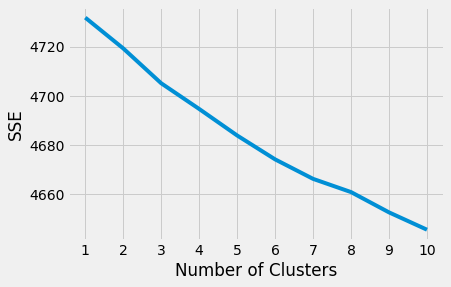

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()                                                                                                # create elbow plot

In [ ]:
kl = KneeLocator(
    range(1,11), sse, curve="convex", direction="decreasing"
)

kl.elbow                                                                                                    # locate knee in the plot

6

Now let's rerun our Kmeans with the optimal number of clusters...

In [ ]:
km = KMeans(n_clusters = 6,
            max_iter = 10000,
            n_init = 50,
            random_state = 42).fit(tv_matrix)
Counter(km.labels_)

Counter({5: 661, 0: 2492, 4: 910, 2: 189, 3: 360, 1: 187})

> ### **D) Prepare Movie Clusters**

Now let's get an idea of the characteristics of each cluster by pulling popular examples of movies within each of the clusters...

In [ ]:
df['kmeans_cluster'] = km.labels_                                                   # assign cluster labels to new column in df

movie_clusters = (df[['title', 'kmeans_cluster', 'popularity']]                     # great a movie clusters df from title, cluster, and popularity
                  .sort_values(by=['kmeans_cluster', 'popularity'],                 # sort in descending order of cluster and popularity
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))                              # group by cluster, show top 20 movies
movie_clusters = movie_clusters.copy(deep=True)
movie_clusters

,title,kmeans_cluster,popularity
546,Minions,5,875.581305
95,Interstellar,5,724.247784
94,Guardians of the Galaxy,5,481.098624
28,Jurassic World,5,418.708552
108,Terminator Genisys,5,202.042635
...,...,...,...
55,Brave,0,125.114374
329,The Lord of the Rings: The Return of the King,0,123.630332
3232,Pulp Fiction,0,121.463076
19,The Hobbit: The Battle of the Five Armies,0,120.965743


In [ ]:
Counter(km.labels_)

Counter({5: 661, 0: 2492, 4: 910, 2: 189, 3: 360, 1: 187})

In [ ]:
feature_names = tv.get_feature_names_out()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(0,6):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Key Features: ['family', 'time', 'must', 'new', 'back', 'young', 'town', 'find', 'home', 'friends', 'film', 'father', 'three', 'lives', 'take']
Popular Movies: ['Pirates of the Caribbean: The Curse of the Black Pearl', 'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1', 'Big Hero 6', 'Whiplash', 'The Dark Knight', 'Fight Club', "Pirates of the Caribbean: Dead Man's Chest", 'The Godfather', 'Gone Girl', 'Rise of the Planet of the Apes', 'The Lord of the Rings: The Fellowship of the Ring', 'Despicable Me 2', "One Flew Over the Cuckoo's Nest", 'Star Wars', 'Brave', 'The Lord of the Rings: The Return of the King', 'Pulp Fiction', 'The Hobbit: The Battle of the Five Armies', 'Iron Man']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['school', 'high', 'high school', 'teacher', 'girl', 'students', 'friends', 'student', 'schools', 'best', 'college', 'life', 'summer', 'new', 'seniors']
Popular Movies: 

**How might you (briefly) describe each of these clusters based on their key features and the top popular movies within them?**

* Cluster 1:
* Cluster 2:
* Cluster 3:
* Cluster 4:
* Cluster 5:
* Cluster 6:


## **2) Affinity Propagation**

Now let's try out a different clustering method, affinity propagation. Remember that this method does not require the user to specify the number of clusters; it does this automatically by finding exemplar observations that can well represent other data points in their cluster.

Because affinity propagation can often lead to the creation of many clusters, we will only examine the top 10 most common (largest) clusters... 

> ### **A) First we will convert our cv_matrix into consine similarity values**

In [ ]:
cosine_sim_features = cosine_similarity(tv_matrix)

> ### **B) Fit the Model to the features**

Keep in mind that one of the downsides of Affinity Propagation is that its computationally expensive, so it runs pretty slow. It took mine over 2 minutes to execute.

In [ ]:
%%time
ap = AffinityPropagation(max_iter=500)
ap.fit(cosine_sim_features)
res = Counter(ap.labels_)
res.most_common(10)

In [ ]:
res

Wow that's a lot of different clusters! How might this impact the interpretability/usefulness of the clustering analysis? Are there benefits to having a larger number of small clusters vs. a small number of large clusters?

> ### **C) Produce the most popular movies per top 10 clusters**

In [ ]:
df['affprop_cluster'] = ap.labels_
filtered_clusters = [item[0] for item in res.most_common(8)]
filtered_df = df[df['affprop_cluster'].isin(filtered_clusters)]
movie_clusters = (filtered_df[['title', 'affprop_cluster', 'popularity']]
                  .sort_values(by=['affprop_cluster', 'popularity'], 
                               ascending=False)
                  .groupby('affprop_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)

# get movies belonging to each cluster
for cluster_num in range(len(filtered_clusters)):
    movies = movie_clusters[movie_clusters['affprop_cluster'] == filtered_clusters[cluster_num]]['title'].values.tolist()
    print('CLUSTER #'+str(filtered_clusters[cluster_num]))
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #99
Popular Movies: ['Minions', 'Interstellar', 'Deadpool', 'Guardians of the Galaxy', 'Jurassic World', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1', 'Big Hero 6', 'Captain America: Civil War', 'Whiplash', 'The Dark Knight', 'Inception', 'Batman v Superman: Dawn of Justice', 'Avatar', 'Fight Club', 'The Avengers', 'The Godfather', 'Gone Girl', 'X-Men: Apocalypse']
--------------------------------------------------------------------------------
CLUSTER #12
Popular Movies: ['The Imitation Game', "Schindler's List", 'Shutter Island', 'Captain America: The First Avenger', 'Unbroken', 'Lawrence of Arabia', 'Enemy at the Gates', 'The Thin Red Line', 'The Great Escape', 'Letters from Iwo Jima', 'Woman in Gold', 'Windtalkers', 'U-571', 'Seven Years in Tibet', 'Memoirs of a Geisha', 'Return to Never Land', 'Black Book', 'Red Tails', 'Miracle at St. Anna', 'The Great Raid']
---------------------------

**This is of course a larger number of clusters than we developed using KMeans, but what are some interesting differences in the way that these two algorithms grouped similar movies?**

## **3) Ward's Hierarchical Clustering**

Finally we apply a hiearchical clustering method using cosine distance as our similarity metric and Ward as our linkage function. We will take the following steps in generating a hierarchy of similar movie clusters:

* A) Convert our cosine similarity features to a cosine distance matrix
* B) Calculte a linkage_matrix using `ward` to apply the Ward's linkage criterion
* C) Plot the hierarchical structure of clusters as a dendrogram

> ### **A & B) Convert the cosine similarity features to cosine distance matrix and calculate linkage matrix**

In [ ]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

linkage_matrix = ward_hierarchical_clustering(tv_matrix)

> ### **C) Plot Hierarchical Structure of Movies as a Dendrogram**

In [ ]:
def plot_hierarchical_clusters(linkage_matrix, movie_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=movie_titles,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: movie_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('movie_hierachical_clusters.png', dpi=200)

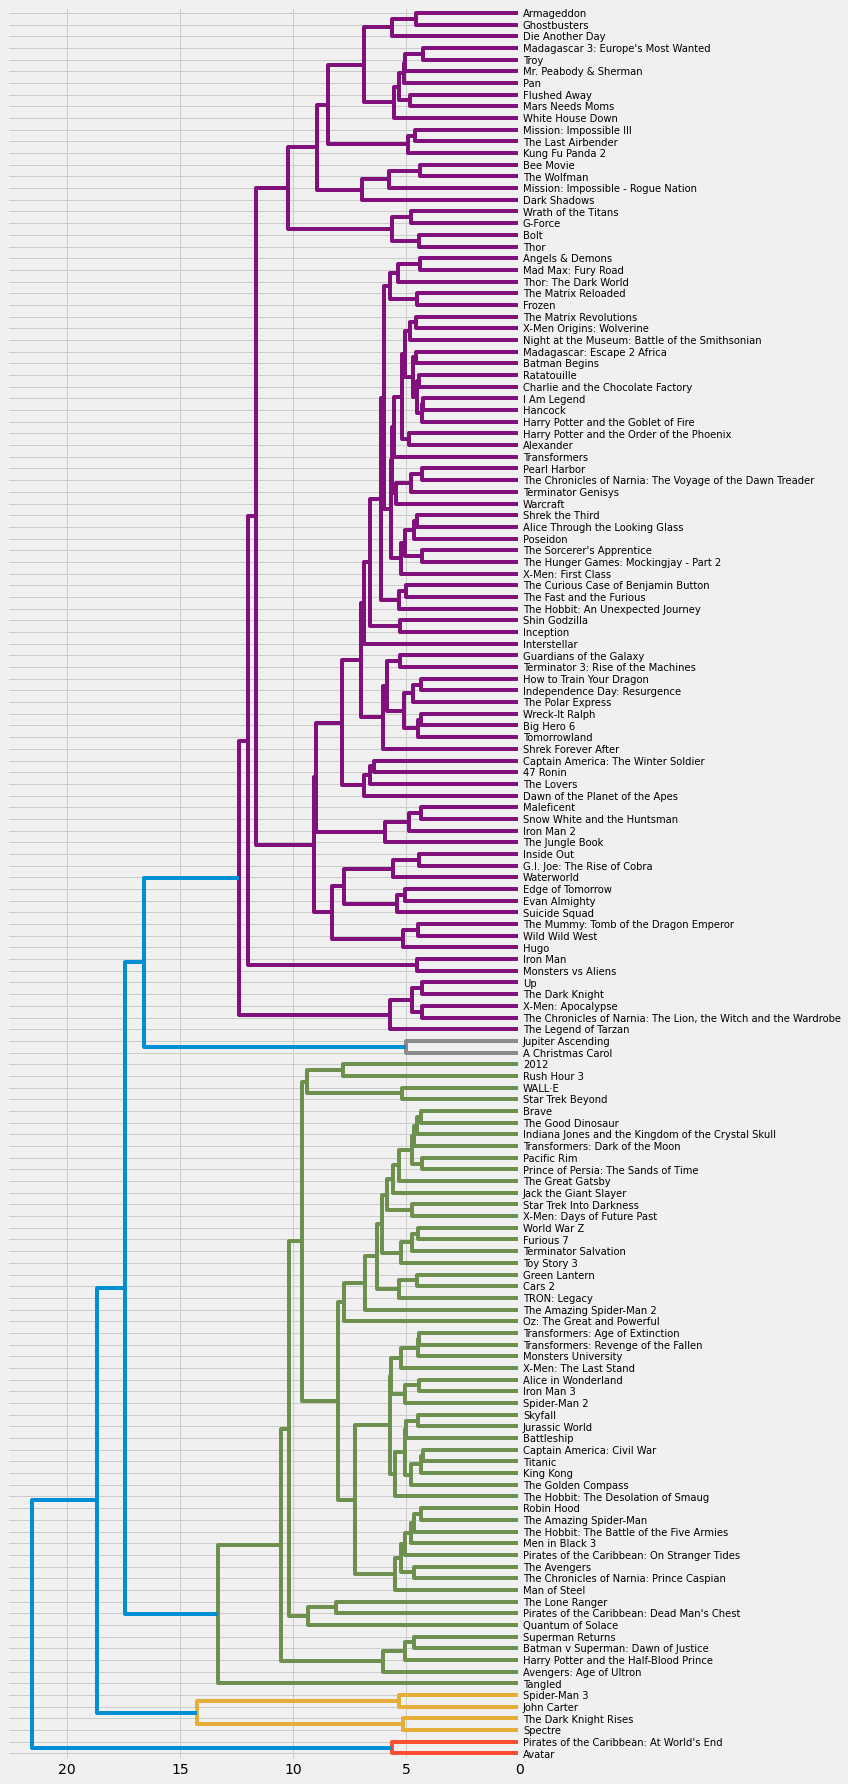

In [ ]:
plot_hierarchical_clusters(linkage_matrix,
                           p=150,
                           movie_data=df,
                           figure_size=(12, 25))

**Based on this dendrogram, what are some interesting observations about the way movies have been grouped together in terms of genre, sub-genre or even sub-sub genres. Provide some examples of movies that could fit into these different levels of genre!**

**Of the three methods of clustering, did you feel any of these methods did the best job in grouping together movies?**